Created on Sun Apr 03 14:58:52 2016
copied the code from exopop_with_ravi.ipynb,

The the original exopop.ipynb from Dan Foreman-Mackey, is found at
http://dan.iel.fm/downloads/notebooks/exopop.ipynb, and the 
accompanying blog post is at
http://dan.iel.fm/posts/exopop/

Adapting this code by adding option to work in the phase space of 
[ insolation , planet radius ] rather than [period , planet radius ]

@author: jcat

Tues. Apr 19: @author mshabram
updating populaiton inference. Powerlaw method for Rp and log10 insolation 

In [40]:
# Omitting the following commands,which  are for use in the notebook environment
# %matplotlib inline
# %config InlineBackend.figure_format = "retina"

#%%=========================================================
# Intialize
# Had to put __future__ before other imports
from __future__ import division, print_function
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
import os
import requests
import pandas as pd
from cStringIO import StringIO

%matplotlib inline
%config InlineBackend.figure_format = "retina"



In [2]:
#%%=========================================================
# Function to download and cache a dataset from the exoplanet archive
# into a pandas frame
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df
    


In [3]:
#%%=========================================================
# Get the stellar catalog and make selection cuts   
import numpy as np
stlr = get_catalog("q1_q17_dr24_stellar")

# Select G dwarfs.
# m = (5300 <= stlr.teff) & (stlr.teff <= 6000)

# Select K dwarfs.
m = (3900 <= stlr.teff) & (stlr.teff <= 5300)

# Select M dwarfs.
# m = (2400 <= stlr.teff) & (stlr.teff <= 3900)

# stellar radius cut
#m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage:

# Minimum dataspan of 2 years
m &= stlr.dataspan > 365.25*2.

# Minimum dutycycle of 1/2
m &= stlr.dutycycle > 0.50

# Minimum data coverage of 2 years
m &= stlr.dutycycle*stlr.dataspan > 365.25*2.

# minimum rms cdpp at 7.5 hour pulse
#m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

# put selected data into pandas data frame
base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))


Selected 40685 targets after cuts


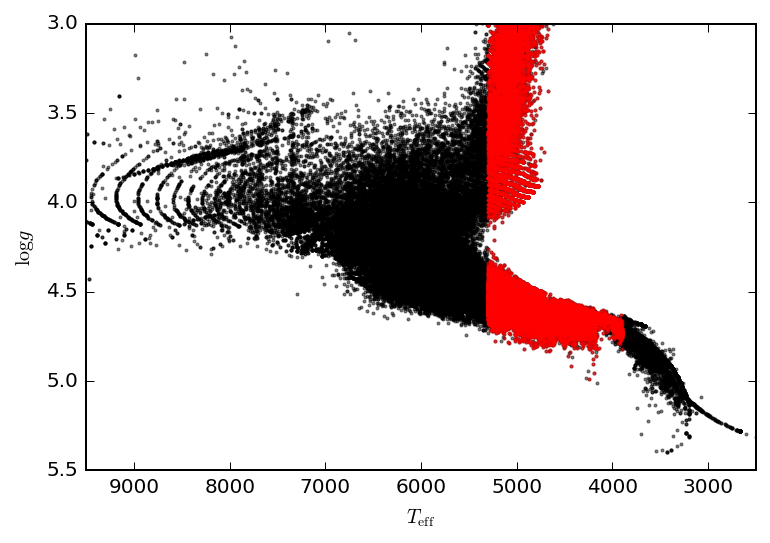

In [41]:
#%%=========================================================
# HR diagram of the selected targets
import matplotlib.pyplot as pl

pl.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
pl.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
pl.xlim(9500, 2500)
pl.ylim(5.5, 3)
pl.ylabel("$\log g$");
pl.xlabel("$T_\mathrm{eff}$");


In [42]:
#%%=========================================================

## TO DO:  Update to select for insolation


# Get the planet catalog and make selection cuts   
kois = get_catalog("q1_q17_dr24_koi")

# Set period and planet radius ranges
period_rng = (20, 320)
rp_rng = (0.75, 2.5)

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])
m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])
m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])

# Only include PCs with MES > 15 for 9.2
m &= kois.koi_max_mult_ev > 15
kois = pd.DataFrame(kois[m])

print("min period = {0} ".format(period_rng[0]))
print("max period = {0} ".format(period_rng[1]))
# print("max MES = {0} ".format(kois.koi_max_mult_ev))
print("Selected {0} KOIs after cuts".format(len(kois)))



min period = 20 
max period = 320 
Selected 67 KOIs after cuts


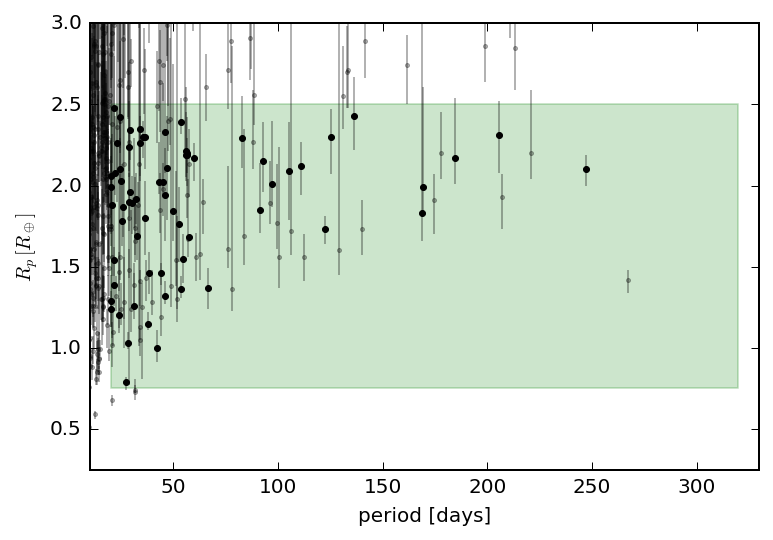

In [43]:
#%%=========================================================
# Plot distribution of measurements in period-radius phase space
yerr = np.abs(np.array(base_kois[["koi_prad_err2", "koi_prad_err1"]])).T
pl.errorbar(base_kois.koi_period, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
pl.plot(kois.koi_period, kois.koi_prad, ".k", ms=6)
pl.fill_between(period_rng, [rp_rng[1], rp_rng[1]], [rp_rng[0], rp_rng[0]], color="g", alpha=0.2)
pl.xlim(period_rng + 10 * np.array([-1, 1]))
pl.ylim(rp_rng + 0.5 * np.array([-1, 1]))
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$");


In [44]:
#%%=========================================================
# Detection efficiency model
from scipy.stats import gamma

def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    # DFM used a multiplier 0f 0.84 instead of 1.0 in the equation below,
    # for Q1-Q16 9.1
    return 1.0* delta_max

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate to the correct CDPP for the duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.

# pgam = gamma(4.65, loc=0., scale=0.98)
# DFM used the parameters above, for Q1-Q16 9.1
# Below parameters for 9.2 Q1-Q17 are from Jessie Christiansen's paper
pgam = gamma(103.0113, loc=0., scale=0.10583)
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, mesthres_vals,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    # DFM used no multiplier in the equation below;
    # Where did the value of 0.78442 come from?
    return 0.78442*pgam.cdf(x)

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)

def get_completeness(star, period, rp, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom
    
#%% This cell contains functions and code for calculating completeness in the
#       phase space of [ log10insolation , planet radius ] 
    
# Construct grids for log10insolation
log10insolation_rng = (-2, 5)
log10insolation = np.linspace(log10insolation_rng[0], log10insolation_rng[1], 57)
rp2 = np.linspace(rp_rng[0], rp_rng[1], 61)
log10insolation_grid, rp_grid2 = np.meshgrid(log10insolation, rp2, indexing="ij")
   
    
def get_completeness_from_log10insolation(star, log10insolation_grid, rp_grid2, e, with_geom=True):
    
    # compute the periods corresponding to an insolation grid
    insolation = 10**log10insolation_grid
    period_grid = get_period_from_insolation( star , insolation )
    
    # completeness 
    completeness = get_completeness(star, period_grid, rp_grid2, e, with_geom=True)
    
    return completeness
    

# Add a function to compute insolation on the period grid, for a given star 
def get_insolation_from_period( star , period ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Semimajor axis of planet in AU
    aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0) 
    
    # Compute insolation
    insolation = (teffStar/teffSun)**4*(rStar/1)**2*(1/aPlanet)**2
    
    return insolation
    
def get_period_from_insolation( star , insolation ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Get semimajor axis from star properties and insolation, using
    # insolation = ( teffStar / teffSun )**4 * ( rStar / 1)**2 * ( 1 / aPlanet )**2
    aPlanet = ( ( teffStar / teffSun )**4 * ( rStar / 1)**2 / insolation )**(0.5)
    
    # Get orbit period in days from semimajor axis of planet in AU and start properties, using
    # aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0)
    period = 365.25 * ( aPlanet/( mStar**(1.0/3.0) ) )**(3.0/2.0)
    
    return period


# Test: compute completeness grid in [ log10insolation , planet radius ] 
# phase space for the first star in the catalog
new_completeness_grid_single_star = get_completeness_from_log10insolation(stlr.iloc[0], log10insolation_grid, rp_grid2, 0.0, with_geom=True)

# Marginalize detection contours over all selected targets
# including the geometric factor
new_completeness = np.zeros_like(log10insolation_grid)
for _, star in stlr.iterrows():
    new_completeness += get_completeness_from_log10insolation(star, log10insolation_grid, rp_grid2, 0.0, with_geom=True)

 


In [45]:
print(stlr.kepid[0])

10022892


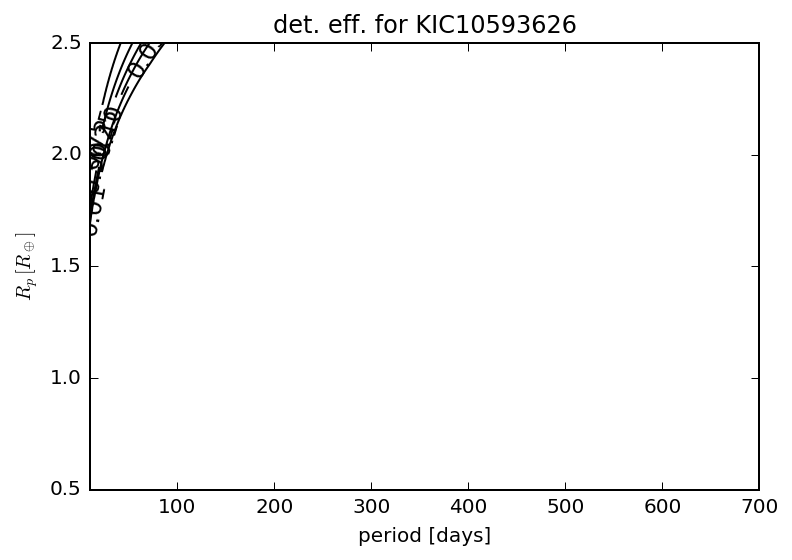

In [52]:
#%%=========================================================
# Reproducing Figure 1 from Burke paper, which is the
# completeness contour for an example target
 
# Note: this fails if keplerId 10031707 is not in the selected catalog;
#   in that case, just choose a different star that is in the catalog 
    
# Choose the star
# star = stlr[stlr.kepid == 10593626].iloc[0]
# First M star
#star = stlr[stlr.kepid == 10031707].iloc[0]
star = stlr[stlr.kepid == stlr.kepid[0]].iloc[0]
# Compute the completeness map on a grid.
period = np.linspace(10, 700, 500)
rp = np.linspace(0.5, 2.5, 421)
X, Y = np.meshgrid(period, rp, indexing="ij")
Z = get_completeness(star, X, Y, 0.0, with_geom=False)

# Plot with the same contour levels as the figure.
c = pl.contour(X, Y, Z, [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
pl.clabel(c, fontsize=12, inline=1, fmt="%.2f") 
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$")
pl.title("det. eff. for KIC10593626");


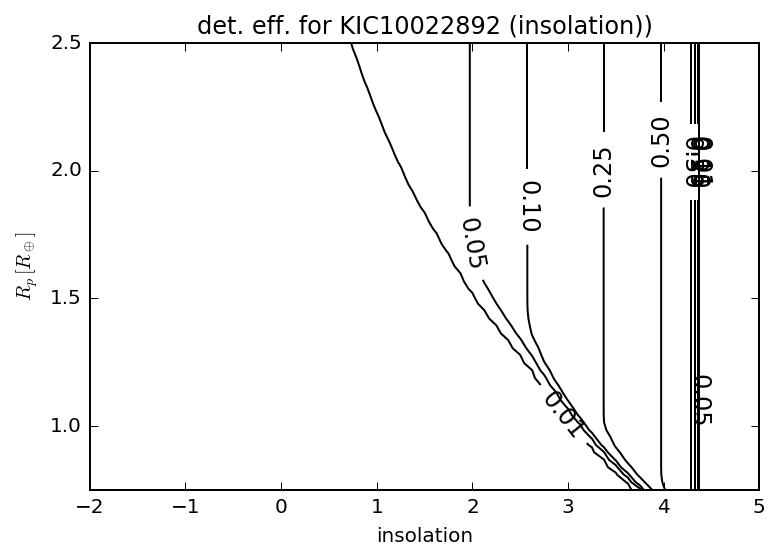

In [54]:
#%%=========================================================
# Reproducing Figure 1 from Burke paper, which is the
# completeness contour for an example target
 
# Repeating for new log10 insolation completeness.  
    
# Choose the star
# star = stlr[stlr.kepid == 10593626].iloc[0]
# First M star
#star = stlr[stlr.kepid == 10031707].iloc[0]
star = stlr[stlr.kepid == stlr.kepid[0]].iloc[0]

# Compute the completeness map on a grid.
X, Y = log10insolation_grid, rp_grid2
Z = get_completeness_from_log10insolation(star, X, Y, 0.0, with_geom=False)

# Plot with the same contour levels as the figure.
c = pl.contour(X, Y, Z, [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
pl.clabel(c, fontsize=12, inline=1, fmt="%.2f") 
pl.xlabel("insolation")
pl.ylabel("$R_p \, [R_\oplus]$")
pl.title("det. eff. for KIC10022892 (insolation))");



In [37]:
#%%=========================================================
# Marginalize detection contours over all selected targets
# including the geometric factor
period = np.linspace(period_rng[0], period_rng[1], 57)
rp = np.linspace(rp_rng[0], rp_rng[1], 61)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")

comp = np.zeros_like(period_grid)
for _, star in stlr.iterrows():
    comp += get_completeness(star, period_grid, rp_grid, 0.0, with_geom=True)



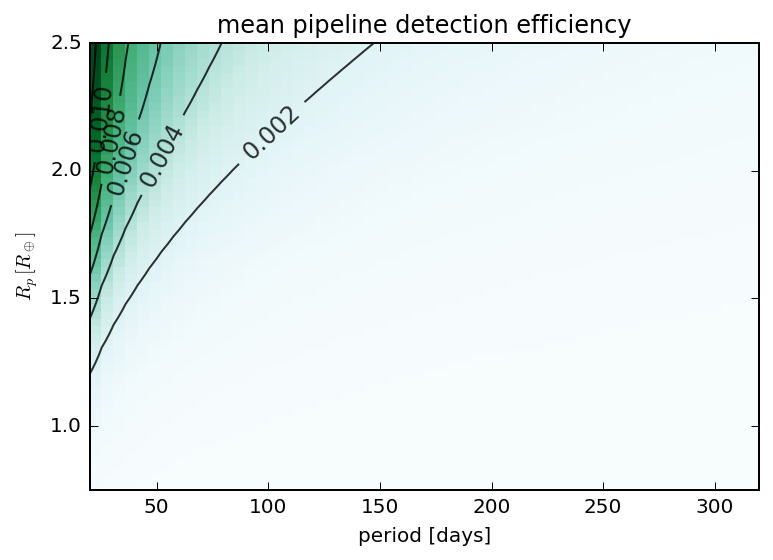

In [47]:
#%%=========================================================
# Plot the average completeness contour
pl.pcolor(period_grid, rp_grid, comp, cmap="BuGn")
c = pl.contour(period_grid, rp_grid, comp / len(stlr),
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
pl.title("mean pipeline detection efficiency")
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$");


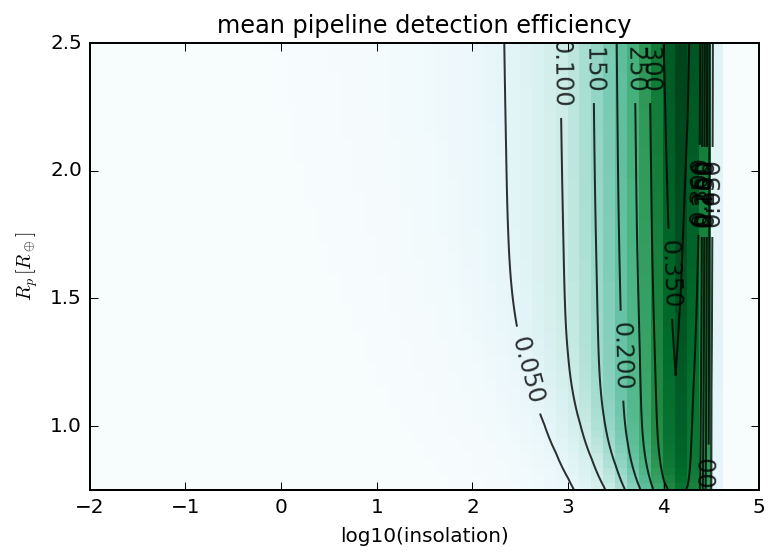

In [48]:
#%%=========================================================
# Plot the average new_completeness contour (insolation)
pl.pcolor(log10insolation_grid, rp_grid, new_completeness, cmap="BuGn")
c = pl.contour(log10insolation_grid, rp_grid, new_completeness / len(stlr),
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
pl.title("mean pipeline detection efficiency")
pl.xlabel("log10(insolation)")
pl.ylabel("$R_p \, [R_\oplus]$");


In [55]:
#%%=========================================================
# Population inference with an independent power law model in P and Rp

# A double power law model for the population.
def population_model(theta, period, rp):
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(period)
    for x, rng, n in zip((period, rp),
                         (period_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(kois.koi_prad)
vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, period_grid, rp_grid) * comp
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(population_model(theta, koi_periods, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just proportional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15


In [60]:
#%%=========================================================
# Population inference with an independent power law model in P and Rp
# !!!!! Note: making use of the additional codes above for computing a 
# completeness grid in the phase space of [ log10insolation , planet radius ], 

# A double power law model for the population.
def population_model_insolation(theta, insolation, rp):
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(insolation)
    for x, rng, n in zip((insolation, rp),
                         (log10insolation_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

# The ln-likelihood function given at the top of this post.
# change to insolation from planet catalog
# koi_periods = np.array(kois.koi_period)
koi_insolation = np.array(kois.koi_insol)
koi_rps = np.array(kois.koi_prad)

vol = np.diff(log10insolation_grid, axis=0)[:, :-1] * np.diff(rp_grid2, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model_insolation(theta, log10insolation_grid, rp_grid2) * new_completeness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(population_model_insolation(theta, koi_insolation, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just proportional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15



In [61]:
#%%=========================================================
# Maximum likelihood solution by minimizing negative log-likelihood
from scipy.optimize import minimize
theta_0 = np.array([np.log(0.75), -0.53218, -1.5])
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)


      fun: 1000000000000000.0
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([-0.28768207, -0.53218   , -1.5       ])


[ 0.49144322]


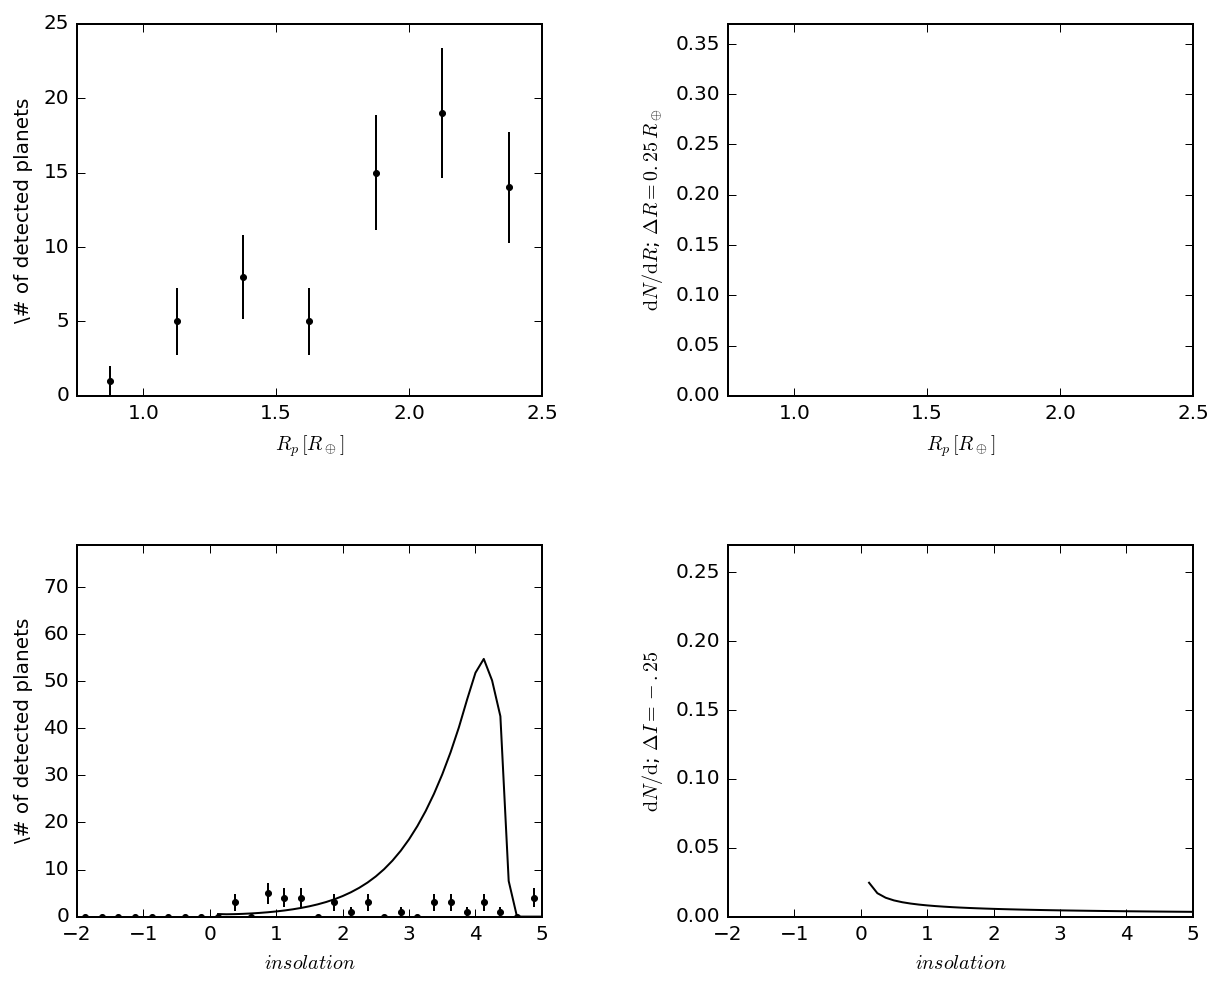

In [70]:
#%%=========================================================
# Plot the maximum likelihood solution

#  Debug starting here.  4.19.16

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), log10insolation_grid.shape[0], log10insolation_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        pop[i] = population_model(p, log10insolation_grid, rp_grid2)
        gamma_earth[i] = population_model(p, 365.25, 1.0) * 365.
        
    fig, axes = pl.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * new_completeness[None, :, :], rp2, x, log10insolation, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp2, x, log10insolation, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Integrate over insolation.
    dx = 0.25
    x = np.arange(log10insolation_rng[0], log10insolation_rng[1] + dx, dx)
    n, _ = np.histogram(koi_insolation, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * new_completeness[None, :, :], 1, 2), log10insolation, x, rp2, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(log10insolation_rng[0], log10insolation_rng[1])
    ax.set_ylim(0, 79)
    ax.set_xlabel("$insolation$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), log10insolation, x, rp2, ax)
    ax.set_xlim(log10insolation_rng[0], log10insolation_rng[1])
    ax.set_ylim(0, 0.27)
    ax.set_xlabel("$insolation$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}$; $\Delta I = -.25\,$")
    
    return gamma_earth

#%%
# Maximum likelihood value of gamma_earth
print(plot_results(r.x));



In [71]:
#%%=========================================================
# Sample from the posterior probability distribution for the population parameters using emcee
import emcee

ndim, nwalkers = len(r.x), 16
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, 1000)
sampler.reset()

# Production.
pos, _, _ = sampler.run_mcmc(pos, 4000)



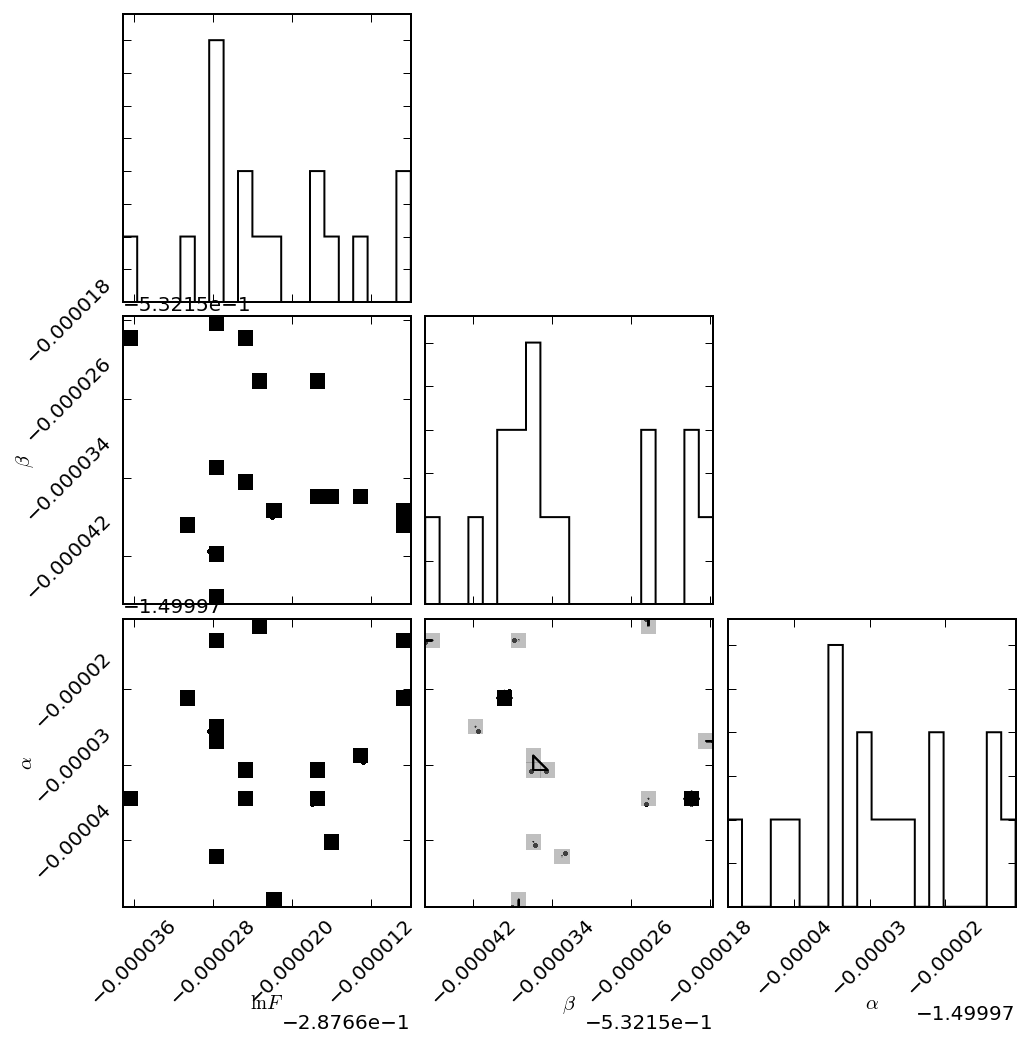

In [72]:
#%%=========================================================
# Triangle plot of PDFs using DFMs corner package
import corner
corner.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);


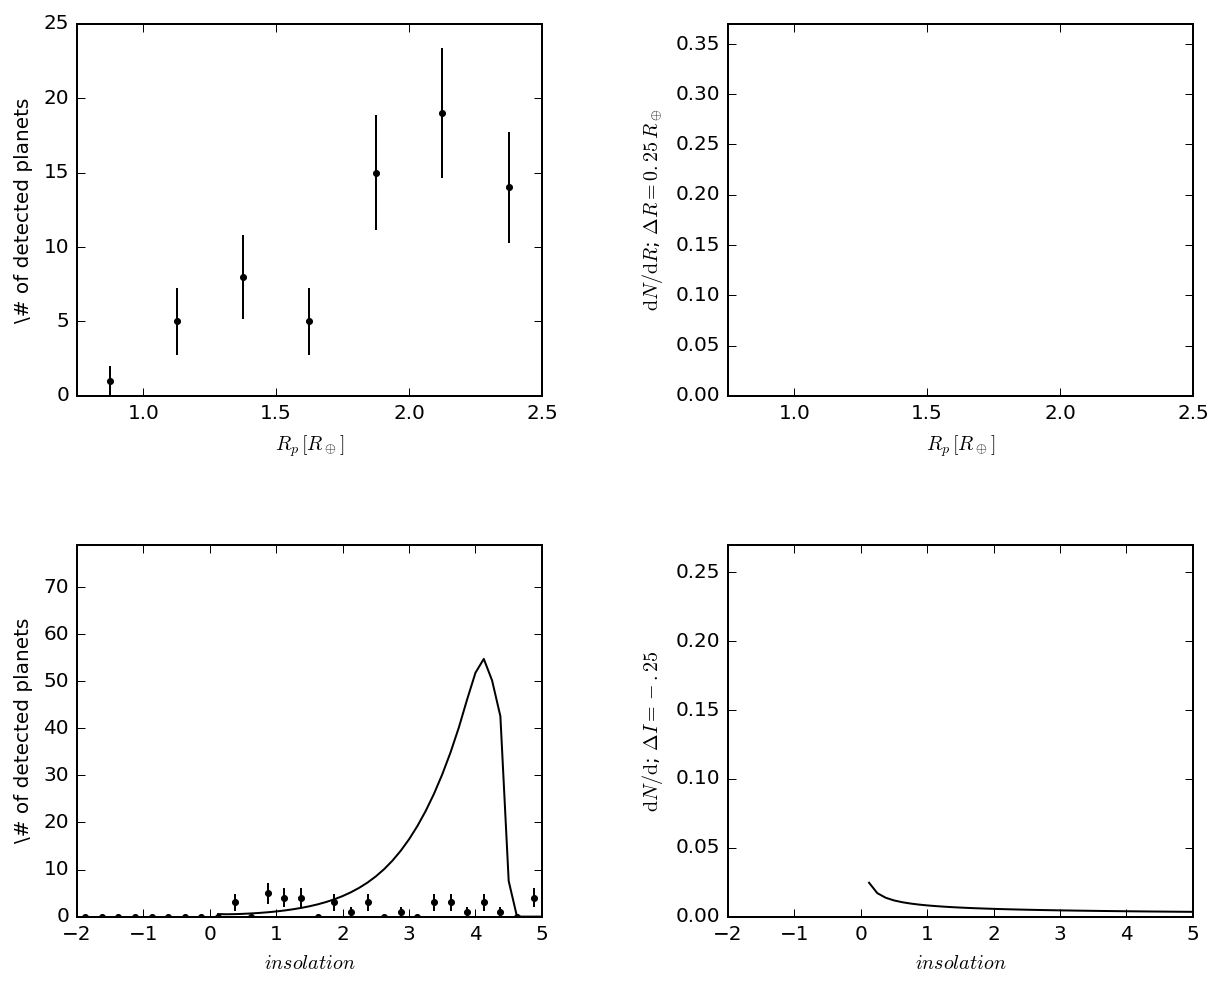

In [73]:
#%%=========================================================
# Plot marginalized posteriors of N and dN/dR
# For Rp, marginalize over P
# For P, marginalize over Rp
# For N, plot also the data and the error bars

# !!!!! Problem -- the following command quickly maxes out my PCs memory and brings
#   it to its knees.    
# Solution -- plot only the last 4000 chains 
gamma_earth = plot_results(sampler.flatchain[60000:63999,:])


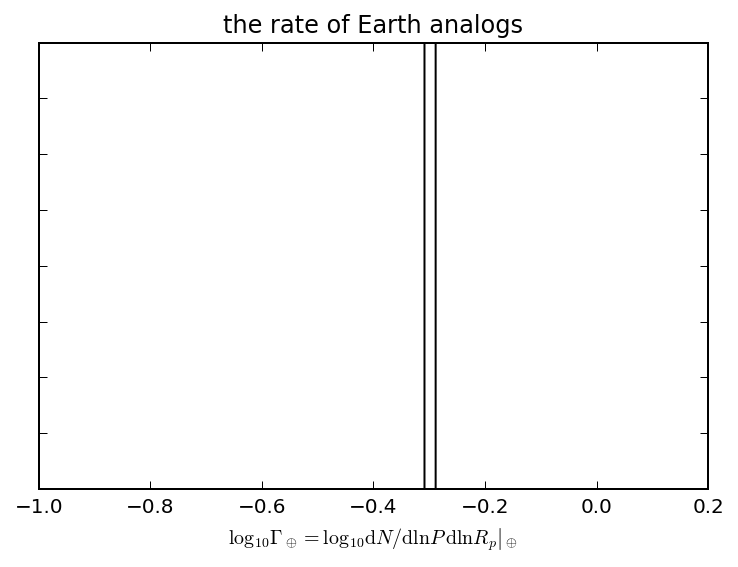

In [74]:
#%%=========================================================
# Plot the PDF of gamma_earth
pl.hist(np.log10(gamma_earth), 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("the rate of Earth analogs")
pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");



<function matplotlib.pyplot.xticks>

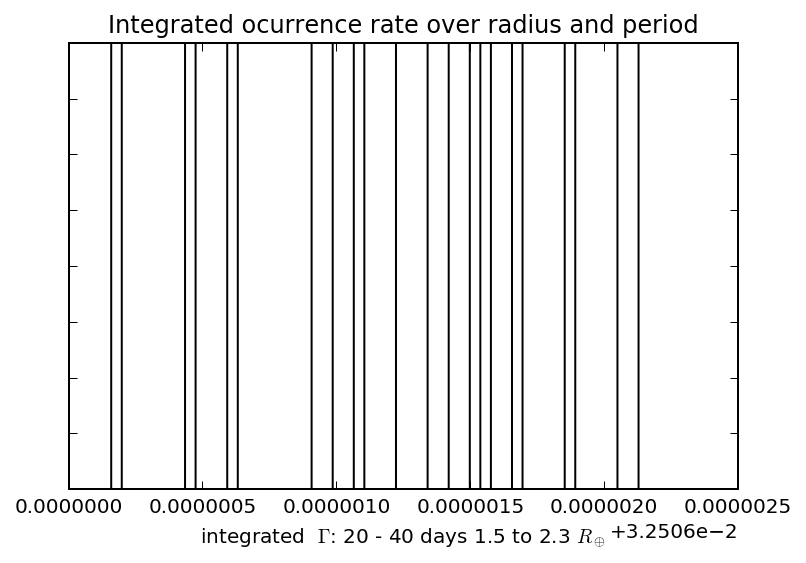

In [75]:
#%%=========================================================
# Integrate the planet density over a given range in period and radius
#   to get the exoplanet occurrence rate predicted by the power law in that region
def integrated_gamma(theta,period1,period2,radius1,radius2):
    lnf0, beta, alpha = theta
    
    # Phase Space Boundaries for our model
    period_rng = (20, 320)
    radius_rng = (0.75, 2.5)
    
    # Compute exoplanet occurrence rate integrated over chosen region of [ period , radius] phase space
    integral_over_period = (period2**(beta + 1) - period1**(beta + 1))/(period_rng[1]**(beta + 1) - period_rng[0]**(beta + 1))
    integral_over_radius = (radius2**(alpha + 1) - radius1**(alpha + 1))/(radius_rng[1]**(alpha + 1) - radius_rng[0]**(alpha + 1))
    eta = integral_over_period*integral_over_radius*np.exp(lnf0)
    
    return eta
    

#%% Compute and plot the posterior PDF for the exoplanet occurence rate in a 
#   desired region of period, radius phase space

# Initialize   
int_gamma_samples = np.empty(len(sampler.flatchain))

# Choose period and radius limits
period1 = 20
period2 = 40
radius1 = 1.5
radius2 = 2.3

for i, theta in enumerate(sampler.flatchain):
    int_gamma_samples[i] = integrated_gamma(theta,period1,period2,radius1,radius2)

# print result for this bin
np.percentile(int_gamma_samples,[16,50,84])

             
# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples, 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("Integrated ocurrence rate over radius and period")
pl.xlabel(r"integrated  $\Gamma$: 20 - 40 days 1.5 to 2.3 $R_\oplus$");
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks
